In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import os
import shutil
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import torchvision.datasets as dsets
import random
import torchsummary
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness = 0.1,
                           contrast = 0.1,
                          saturation = 0.1),
    transforms.RandomHorizontalFlip(0.1),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                     p = 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])


test_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()])

In [5]:
train = dsets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test = dsets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

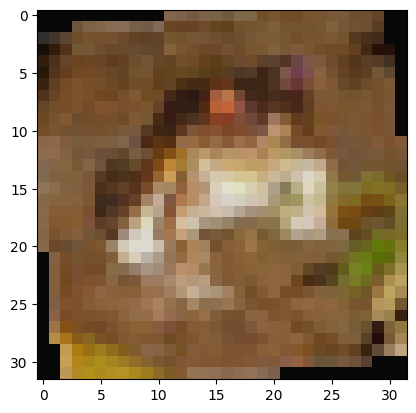

In [7]:
plt.imshow(train[0][0].permute(1,2,0))

In [8]:

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def plot_images(dataset, num_images=5, class_names=None):
    num_images = min(num_images, len(dataset))
    indices = random.sample(range(len(dataset)), num_images)

    rows = (num_images + 3) // 4
    cols = min(num_images, 4)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)

        label_name = class_names[label] if class_names else "Unknown"
        label_text = f"{label}: {label_name}"
        size_text = f"Size: {image.shape[0]}x{image.shape[1]}"

        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"{label_text}\n{size_text}", fontsize=8)


    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.show()




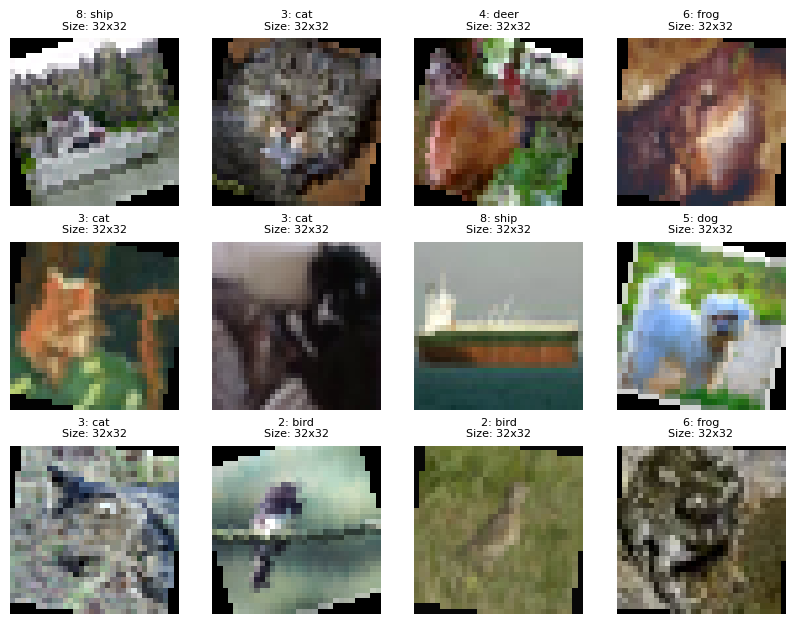

In [9]:
plot_images(train,12,class_names)

In [10]:

mps_device = torch.device("cuda" if torch.cuda.is_available else "cpu")
class CNN(nn.Module):


    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        # Calculation of how we got 8*8 is mentioned in the below comment

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

In [11]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):

    # Global variable
    N_test = len(test_loader.dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(mps_device)
    train_cost_list = []
    val_cost_list = []

    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(mps_device)
            y = y.to(mps_device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()

        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0

        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(mps_device)
            y_test = y_test.to(mps_device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()

        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))

    return accuracy_list, train_cost_list, val_cost_list

In [12]:
model = CNN(number_of_classes = 10)

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list = train_model(model=model,
                                                                   n_epochs=20,
                                                                   train_loader=train_loader,
                                                                   validation_loader=test_loader,
                                                                   optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 2.0059  | Validation Loss : 1.6169  | Validation Accuracy : 42.35%
--> Epoch Number : 2  | Training Loss : 1.5412  | Validation Loss : 1.4286  | Validation Accuracy : 47.5%
--> Epoch Number : 3  | Training Loss : 1.3685  | Validation Loss : 1.3248  | Validation Accuracy : 52.17%
--> Epoch Number : 4  | Training Loss : 1.2783  | Validation Loss : 1.191  | Validation Accuracy : 57.35%
--> Epoch Number : 5  | Training Loss : 1.2021  | Validation Loss : 1.1529  | Validation Accuracy : 58.88%
--> Epoch Number : 6  | Training Loss : 1.1461  | Validation Loss : 1.0776  | Validation Accuracy : 63.13%
--> Epoch Number : 7  | Training Loss : 1.1021  | Validation Loss : 1.1063  | Validation Accuracy : 61.37%
--> Epoch Number : 8  | Training Loss : 1.0721  | Validation Loss : 1.0089  | Validation Accuracy : 65.26%
--> Epoch Number : 9  | Training Loss : 1.0397  | Validation Loss : 0.9979  | Validation Accuracy : 65.3%
--> Epoch Number : 10  | Training Loss :

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_2(nn.Module):

    # Constructor
    def __init__(self, out_1=32, out_2=64, out_3=128, out_4=256, number_of_classes=10):
        super(CNN_2, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_1)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(out_3)
        self.cnn4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(out_4)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.cnn5 = nn.Conv2d(in_channels=out_4, out_channels=out_4, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(out_4)
        self.cnn6 = nn.Conv2d(in_channels=out_4, out_channels=out_4, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(out_4)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(out_4 * 4 * 4, 512)  # Adjusted based on final feature map size
        self.fc2 = nn.Linear(512, number_of_classes)

    # Prediction
    def forward(self, x):
        x = F.relu(self.bn1(self.cnn1(x)))
        x = F.relu(self.bn2(self.cnn2(x)))
        x = self.maxpool1(x)

        x = F.relu(self.bn3(self.cnn3(x)))
        x = F.relu(self.bn4(self.cnn4(x)))
        x = self.maxpool2(x)

        x = F.relu(self.bn5(self.cnn5(x)))
        x = F.relu(self.bn6(self.cnn6(x)))
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
model_1 = CNN_2(out_1=32, out_2=64, out_3=128, out_4=256, number_of_classes=10)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_1.parameters(), lr = learning_rate, momentum = 0.2)

accuracy_list_normal, train_cost_list, val_cost_list = train_model(model=model_1,
                                                                   n_epochs=20,
                                                                   train_loader=train_loader,
                                                                   validation_loader=test_loader,
                                                                   optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.6062  | Validation Loss : 1.4138  | Validation Accuracy : 47.57%
--> Epoch Number : 2  | Training Loss : 1.1816  | Validation Loss : 1.7911  | Validation Accuracy : 50.1%
--> Epoch Number : 3  | Training Loss : 0.9752  | Validation Loss : 1.0728  | Validation Accuracy : 61.56%
--> Epoch Number : 4  | Training Loss : 0.8685  | Validation Loss : 1.1695  | Validation Accuracy : 63.37%
--> Epoch Number : 5  | Training Loss : 0.7813  | Validation Loss : 0.8111  | Validation Accuracy : 73.1%
--> Epoch Number : 6  | Training Loss : 0.7232  | Validation Loss : 0.671  | Validation Accuracy : 76.81%
--> Epoch Number : 7  | Training Loss : 0.6722  | Validation Loss : 0.7138  | Validation Accuracy : 74.98%
--> Epoch Number : 8  | Training Loss : 0.63  | Validation Loss : 0.5577  | Validation Accuracy : 80.73%
--> Epoch Number : 9  | Training Loss : 0.5927  | Validation Loss : 0.5383  | Validation Accuracy : 81.89%
--> Epoch Number : 10  | Training Loss : 0

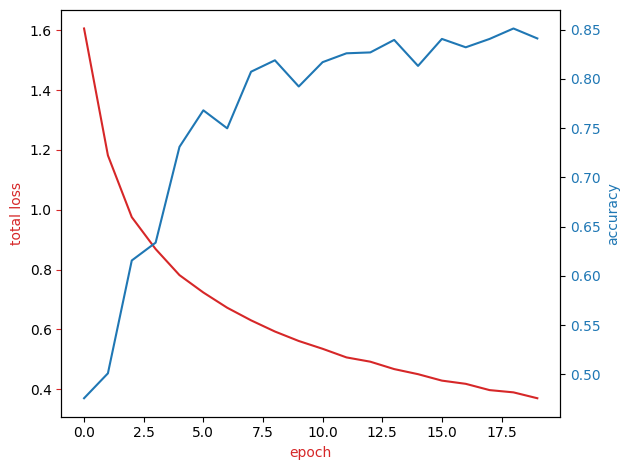

In [22]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot( accuracy_list_normal, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

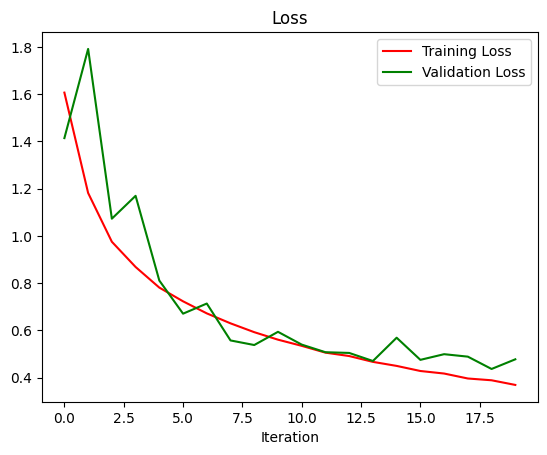

In [23]:
plt.plot(train_cost_list, 'r', label='Training Loss')
plt.plot(val_cost_list,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()